In [143]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
%matplotlib ipympl
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt

# Import Data

In [2]:
#Import data
ADV1data = xr.open_dataset('ADV/adv1_final.nc')
ADV2data = xr.open_dataset('ADV/adv2_final.nc')
TEMPdata = xr.open_dataset('Temperature/temp_final.nc')

# Estimating Wave Parameters and Turbulent Dissipation

The ADV recorded presure and 3-dimensional velocity at 32Hz for 20-minute bursts every hour, resulting in 38400 total samples per burst. Any data points with a single beam correlation under 60%, a signal-to-noise ratio below 10dB, or an instrument tilt more than 5 degrees were removed. After removing poor quality data, the remaining velocity points were run through the "expanding ellipse" despiking algorithm used in Wheeler & Giddings (2023). The remaining gaps in the time series were repaired using methods outlined in Feddersen (2010), where gaps within 1 second in length are linearly interpolated and longer gaps are averaged using the original data. All despiked and repaired data are labelled as "unoriginal", where a ratio of unoriginal samples to total samples can be used to assess the general quality of each burst. 

To estimate wave parameters, pressure spectra were calculated for each burst. Each burst was linearly detrended, split into 60 second segments, and ensemble averaged using a Hann window with 50% overlap, resulting in 107 degrees of freedom (Thomson & Emery, 2014). Following the methods described in Jones and Monosmith (2007), pressure spectra ($S_{pp}$) were converted to surface elevation spectra ($S_{\eta\eta}$) via linear wave theory and used to extrapolate an $\omega^{-4}$ wave model tail beyond this ADV's pressure sensor noise floor at around 0.4Hz. Significant wave height ($H_{s}$) and average wave period ($T_{avg}$) were estimated from $S_{\eta\eta}$ with the $\omega^{-4}$ tail via the methods described in Jones and Monosmith (2007). The peak wave period ($T_{peak}$) was defined as the period where $S_{\eta\eta}$ was largest.

In [ ]:
adv1Spectra = vt.ADV_spectraDS(ADV1data,TEMPdata,selBurstNumbers=None,segLength=60,window='hann',pNoisefloorFreq=.4,vNoisefloorFreq=3.5,wtNoisefloorFactor=12,wtPeakwaveFactor=1.1,wtSlope = -4)
adv2Spectra = vt.ADV_spectraDS(ADV2data,TEMPdata,selBurstNumbers=None,segLength=60,window='hann',pNoisefloorFreq=.4,vNoisefloorFreq=3.5,wtNoisefloorFactor=12,wtPeakwaveFactor=1.1,wtSlope = -4)
adv1Spectra.to_netcdf('Dissipation/adv1Spectra_final.nc')
adv2Spectra.to_netcdf('Dissipation/adv2Spectra_final.nc')

Turbulent kinetic energy dissipation rate ($\epsilon$) was estimated using the power law fit of the vertical velocity spectra ($S_{ww}(\omega)$) within the inertial subrange (ISR) with the smallest least square error from -5/3 slope (Kolmogorov's Law). The lower frequency limits of the ISR were determined by converting $S_{pp}$ to vertical velocity spectra ($S_{w'w'}$) via linear wave theory, to show the surface gravity wave signal. The discrete boundary was defined as the cutoff frequency of the $S_{pp}$ noise floor, since this is where $S_{w'w'}$ begins to diverge from the velocity spectra. The upper frequency cutoff was defined as the beginning of the $S_{ww}$ noise floor at 3.5Hz. Within these boundaries, a power law was fit to all combinations of frequencies, requiring a minimum frequency range of 1Hz. $\epsilon$ was calculated for each of the fits via the following equation from Gerbi et al. (2009):

$\epsilon$ = $\Biggl \langle \left[ \frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)} \right] ^\frac{3}{2} \Biggr \rangle$

where $S_{ww}(\omega)$ is the vertical velocity spectra, $\omega$ is the radian frequency, $\alpha$ is Komogorov's constant of 1.5, and $J_{33}(\omega)$ is an integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities derived, and the angle brackets represent the mean over the frequencies in the ISR. Each estimate of epsilon is run through a series of tests derived from multiple studies (Jones & Monosmith (2008); Gerbi et al. (2009); Feddersen (2010); Wheeler & Giddings (2023)) in order to generate robust values of $\epsilon$ that are accepted by a broad range of requirements. Any estimate of $\epsilon$ that doesn't meet all requirements is rejected. From the remaining estimates, the power law fit with the least squares error from Komogorov's Law is selected as the final estimate. This entire process, as well as all equations used, are expanded upon in the appendix.

In [3]:
#Import data
adv1Spectra = xr.open_dataset('Dissipation//adv1Spectra_final.nc')
adv2Spectra = xr.open_dataset('Dissipation//adv2Spectra_final.nc')

In [ ]:
eps1 = vt.EpsCalc_from_SpectraDS(adv1Spectra, TEMPdata, minimumGap=1, noiseFrequency = None)
eps2 = vt.EpsCalc_from_SpectraDS(adv2Spectra, TEMPdata, minimumGap=1, noiseFrequency = None)

In [7]:
eps1.to_netcdf('Dissipation/eps1_final.nc')
eps2.to_netcdf('Dissipation/eps2_final.nc')

# Plotting the Spectra

In [3]:
#Import data
eps1 = xr.open_dataset('Dissipation/eps1_final.nc')
eps2 = xr.open_dataset('Dissipation/eps2_final.nc')

In [119]:
#Find the absolute best values of epsilon
ds = eps1.copy(deep=True)
ds.BurstCounter.where((ds.UpOrigRatio<.1)&(ds.epsLRPval>.05)&
                      (ds.R_ratio>.5)&(ds.R_ratio<2), drop=True)

<xarray.DataArray 'BurstCounter' (time_start: 19)>
array([13., 17., 21., 29., 39., 50., 51., 53., 54., 55., 64., 74., 76.,
       77., 85., 87., 89., 90., 91.])
Coordinates:
  * time_start  (time_start) datetime64[ns] 2022-08-02T21:40:00 ... 2022-08-0...

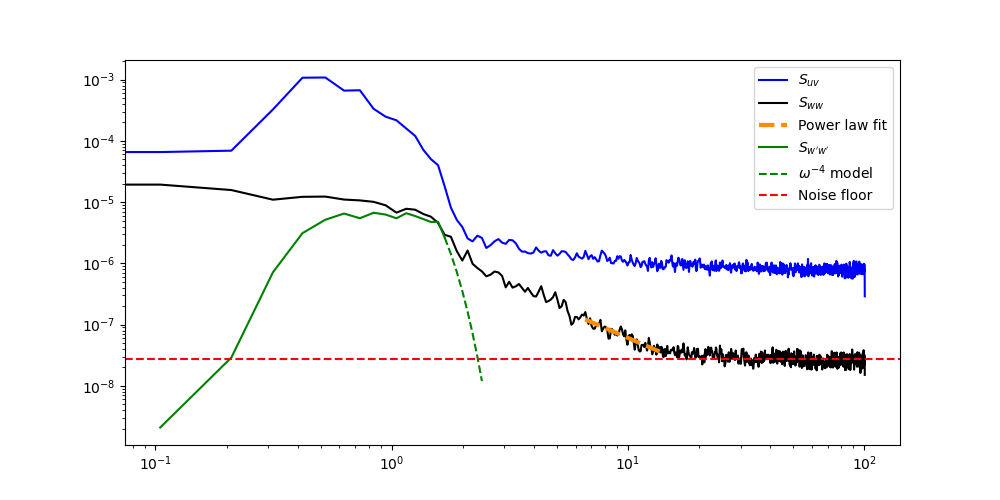

In [156]:
#Check how individual burst spectra look
burst = 91
ds_sub = ds.where(ds.BurstCounter.isin(burst),drop=True)
lb = int(ds_sub.lowBound.values[0])
ub = int(ds_sub.highBound.values[0])

muFit = ds_sub.Int[0] * ds_sub.omega[lb:ub]**ds_sub.Mu[0]
kolFit = ds_sub.KolFitInt[0] * ds_sub.omega[lb:ub]**(-5/3)
fig, axs = plt.subplots(figsize=(10,5))

#Plot S_uv
axs.loglog(ds_sub.omega, (ds_sub.Suu[0]+ds_sub.Svv[0])/2, '-', color='Blue', label = '$S_{uv}$')
#axs.axhline(y = SuvNF, ls = '--', color = 'r')
#Plot S_ww
axs.loglog(ds_sub.omega, ds_sub.Sww[0], '-k', label = r'$S_{ww}$')
axs.loglog(ds_sub.omega[lb:ub], muFit, ls='--',color='darkorange', lw = 3, label = 'Power law fit')
#axs.loglog(ds_sub.omega[lb:ub], kolFit, ls = '-.',color = 'Purple', label = 'Kolmogorov Law')

#Plot S_w'w' without wavetail
axs.loglog(ds_sub.omega[:int(ds_sub.WavetailStart.values[0])+1],ds_sub.SwwPrime[0][:int(ds_sub.WavetailStart.values[0])+1],
           '-g', label = r"$S_{w'w'}$")
#Plot S_w'w' wavetail
axs.loglog(ds_sub.omega[int(ds_sub.WavetailStart.values[0]):int(ds_sub.WavetailEnd.values[0])],
           ds_sub.SwwPrime[0][int(ds_sub.WavetailStart.values[0]):int(ds_sub.WavetailEnd.values[0])],
           '--g', label = r"$\omega^{-4}$ model")

#Plot where the velocity noisefloor lies
axs.axhline(y = ds_sub.VelocityNoisefloor.values, ls = '--', color = 'r', label = 'Noise floor')

axs.legend()

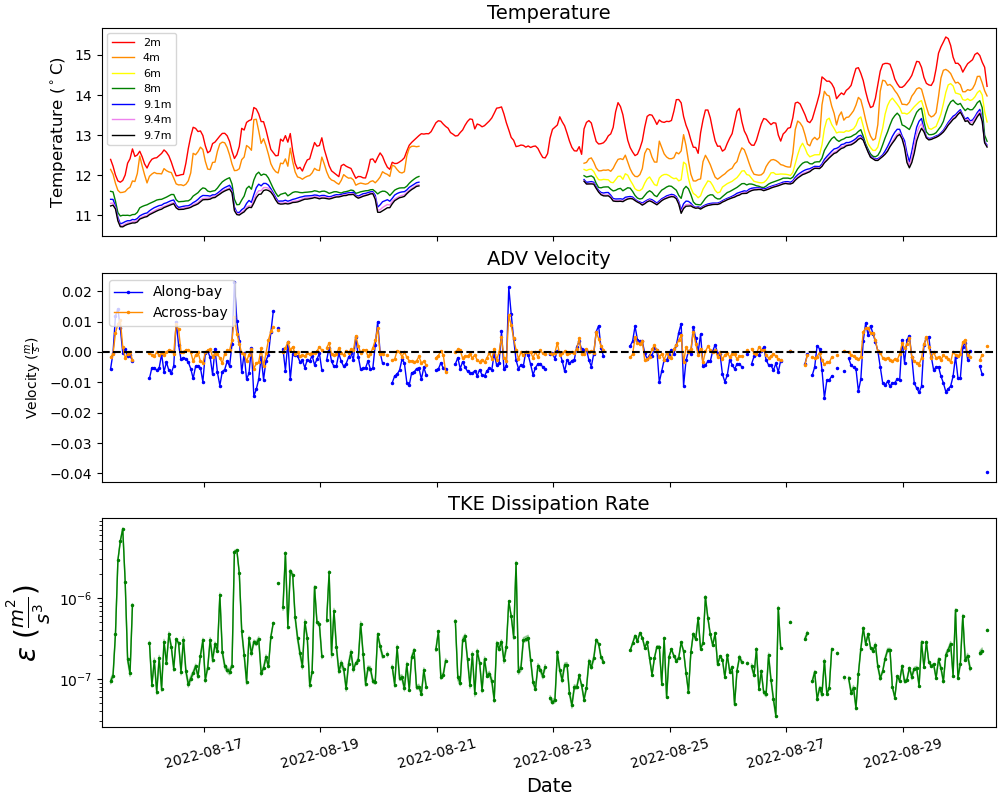

In [149]:
#Plot dissipation as a time series



#Set the resample time and offset times for syncing time series
rSamp = '60Min'
offset = '40Min'

#Additional variables for time series quality control
badDataCutoff = .2 #Ratio of bad data to total number of samples

def eps_timeseries_plot(EPSdata, ADVdata, TEMPdata, badDataCutoff, rSamp = None, offset = None, saveFigAs = None):

    #Retrieve datasets
    epsDS = EPSdata.copy(deep=True)
    advDS = ADVdata.copy(deep=True)
    tempDS = TEMPdata.copy(deep=True)
    
    timeStart = epsDS.time_start[0] #Start of time series defaults to beginning of 
    timeEnd = epsDS.time_start[-1]  #dissipation dataset

    #Trim all bad epsilon data based on function parameters
    epsDS = epsDS.where((epsDS.UpOrigRatio<=badDataCutoff))
    epsDS = epsDS.sel(time_start = slice(timeStart, timeEnd))

    #Trim temperature data to selected time frame
    Temp = tempDS.Temperature.sel(time = slice(timeStart, timeEnd)).resample(time = rSamp, offset = offset).mean()

    #Trim all bad adv data using the bad data ratio
    goodBursts = advDS.burst.where(advDS.PrimOrigRatio<=badDataCutoff,drop=True)
    Prim = advDS.Primary.where(advDS.BurstNum.isin(goodBursts)).dropna(dim='time',how='all')
    Sec = advDS.Secondary.where(advDS.BurstNum.isin(goodBursts)).dropna(dim='time',how='all')
    Prim = Prim.sel(time = slice(timeStart, timeEnd)).resample(time = rSamp, offset = offset).mean()
    Sec = Sec.sel(time = slice(timeStart, timeEnd)).resample(time = rSamp, offset = offset).mean()

    fig,axs=plt.subplots(3,1,constrained_layout=True,figsize=(10,8),sharex=True)

    #Temperature
    axs[0].set_title('Temperature', size=14) 
    axs[0].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
    axs[0].plot(Temp.time, Temp.T, lw = 1)
    axs[0].set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
    axs[0].tick_params(axis = 'x', labelrotation = 15)
    axs[0].margins(x=.01)
    axs[0].legend(['2m', '4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left', fontsize=8)

    #Velocity
    axs[1].set_title('ADV Velocity', size=14)
    axs[1].plot(Prim.time, Prim, '.-b', ms = 3, lw = 1, label = 'Along-bay')
    axs[1].plot(Sec.time, Sec, '.-', color='darkorange', ms = 3, lw = 1, label = 'Across-bay')
    axs[1].axhline(y=0, ls = '--', color='black')
    axs[1].set_ylabel(r'Velocity ($\frac{m}{s}$)')
    axs[1].tick_params(axis = 'x', labelrotation = 15)
    axs[1].margins(x=.01)
    axs[1].legend(loc='upper left')

    axs[2].set_title('TKE Dissipation Rate', size=14)
    axs[2].plot(epsDS.time_start, epsDS.eps, '.-g', ms = 3, lw = 1)
    lowerCI = epsDS.eps - epsDS.epsErr
    upperCI = epsDS.eps + epsDS.epsErr
    axs[2].fill_between(epsDS.time_start, lowerCI, upperCI, color='green', alpha=0.3)
    axs[2].tick_params(axis = 'x', labelrotation = 15)
    axs[2].set_ylabel(r'$\epsilon$ $(\frac{m^{2}}{s^{3}})$', fontsize=20)
    axs[2].set_xlabel('Date', fontsize=14)
    axs[2].margins(x=.01)
    axs[2].set_yscale("log")

In [ ]:
def vecEpsPlotter(vecDS, tempDS, epsDS, timeFrame = None, saveFig = False, filename = None, returnBnum = False):
    
    if timeFrame is not None:
        tempDep = tempDS.sel(dict(time=slice(str(timeFrame[0]), str(timeFrame[-1])))).resample(time='20Min').mean()

        vecDS = vecDS.sel(dict(time=slice(str(timeFrame[0]), str(timeFrame[-1]))))
        gb = np.unique(vecDS.burst.where((vecDS.dPrimary < .25) & (vecDS.burst.isin(vecDS.BurstNum)), drop=True))
        advDep = vecDS.Primary.where(vecDS.BurstNum.isin(gb)).resample(time='20Min').mean()
        advDep = advDep.where(advDep.isnull()==False, drop=True)

        epsDep = epsDS.sel(dict(bNum=slice(gb[0], gb[-1]))).dropna(dim="bNum", how = 'all')
        epsDep = epsDep.where(epsDep.eps.isnull()==False, drop=True)
    
    else:
        tempDep = tempDS.sel(dict(time=slice(epsDS.timeStart.values[0], epsDS.timeStart.values[-1]))).resample(time='20Min').mean()

        gb = vecDS.burst.where(vecDS.dPrimary < .25, drop=True)
        advDep = vecDS.Primary.where(vecDS.BurstNum.isin(np.unique(gb))).resample(time='20Min').mean()
        advDep = advDep.where(advDep.isnull()==False, drop=True)

        epsDep = epsDS.where(epsDS.eps.isnull()==False).dropna(dim="bNum", how="all")

    #Initialize plot
    plt.figure(figsize = (20,16))
    
    # TEMPERATURE
    plt.subplot(311)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=0), 'r-', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=1), 'darkorange', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=2), 'y-', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=3), 'g-', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=4), 'indigo', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=5), 'b-', lw = 1)
    plt.plot(tempDep.time, tempDep.Temperature.isel(depth=6), 'k-', lw = 1)

    plt.ylabel("Temperature (Celsius)", fontsize=14)
    plt.margins(x=.01)
    plt.title('Temperature within SWC Kelp Forest Mooring')
    plt.legend(['2m','4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left')
    
    # PRIMARY VELOCITY
    plt.subplot(312)
    plt.plot(advDep.time, advDep, '.-b', label = 'ADV-U (20-min average)')
    plt.ylim(-.05,.05)
    #plt.legend(loc = 'upper left')
    plt.axhline(y=0, c='black', lw=2)
    plt.margins(x=.01)
    plt.ylabel('Velocity (m/s)', fontsize=14)
    plt.title('Primary velocity 1m Above Seafloor')
    
    # TURBULENT DISSIPATION
    plt.subplot(313)
    plt.yscale("log")
    plt.plot(epsDep.timeStart, epsDep.eps, '.-g', ms = 6, lw=1)
    lowerCI = epsDep.eps - epsDep.epsErr
    upperCI = epsDep.eps + epsDep.epsErr
    plt.fill_between(epsDep.timeStart, lowerCI, upperCI, color='green', alpha=0.3)
    plt.margins(x=.01)
    plt.ylabel(r'$\epsilon$ $(\frac{m^{2}}{s^{3}})$', fontsize=20)
    plt.xlabel('Date', fontsize=14)
    plt.title('TKE Dissipation Rate')
    
    if saveFig:
        plt.savefig(str(filename))
    if returnBnum:
        return np.unique(epsDep.bNum)

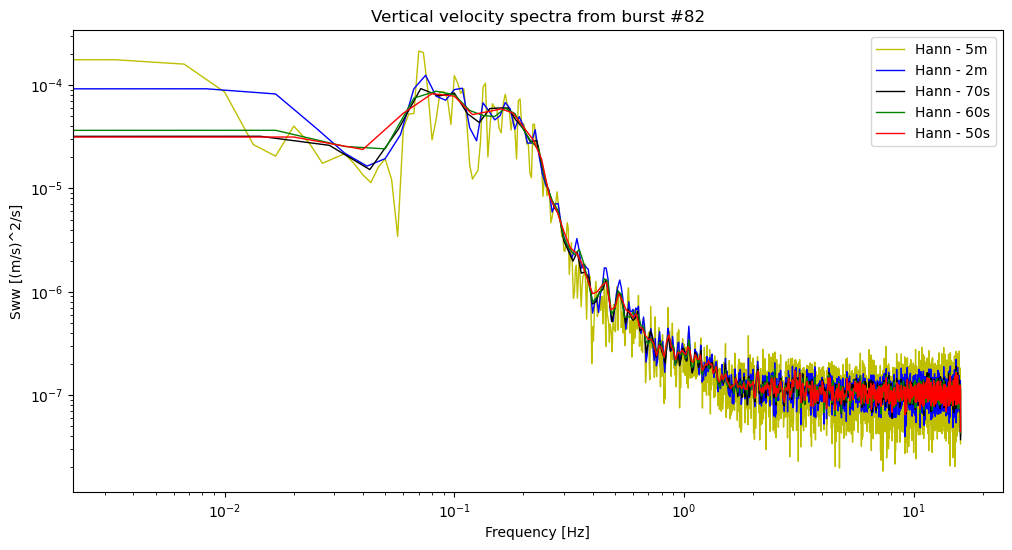

In [7]:
# Hanning window provides best dof
# 50s window smooths out alot of lower frequency wave noise, and some spectra within ISR
# 60s window provides resolution of 70s without as much chatter
# 70s yield good resolution but many spikes at higher frequencies

# Compare window types and segment lengths

# Select single "good" data burst
# Burst 76 provides a good looking spectral curve, so it will be used
# to test eps estimate parameters
burst_number = 82
ds = ADV1data.copy(deep=True)
burst = ds.Up.where((ds.BurstNum.isin(burst_number)), drop = True)

# Fedderson 2010 and 2007 uses combination of 50s and 70s windows
# Both Hann and Hamming windows used through the literature
Fw_hann50s, Sw_hann50s = welch(burst, fs=32, nperseg= 1600, window='hann', detrend = 'linear') # Vertical velocity spectra
Fw_hann60s, Sw_hann60s = welch(burst, fs=32, nperseg= 1920, window='hann', detrend = 'linear')
Fw_hann70s, Sw_hann70s = welch(burst, fs=32, nperseg= 2240, window='hann', detrend = 'linear')
Fw_hann2m, Sw_hann2m = welch(burst, fs=32, nperseg= 120*32, window='hann', detrend = 'linear')
Fw_hann5m, Sw_hann5m = welch(burst, fs=32, nperseg= 300*32, window='hann', detrend = 'linear')

plt.figure(figsize = (12,6))
plt.title('Vertical velocity spectra from burst #' + str(burst_number))
plt.loglog(Fw_hann5m, Sw_hann5m, '-y', lw = 1, label = 'Hann - 5m')
plt.loglog(Fw_hann2m, Sw_hann2m, '-b', lw = 1, label = 'Hann - 2m')
plt.loglog(Fw_hann70s, Sw_hann70s, '-k', lw = 1, label = 'Hann - 70s')
plt.loglog(Fw_hann60s, Sw_hann60s, '-g', lw = 1, label = 'Hann - 60s')
plt.loglog(Fw_hann50s, Sw_hann50s, '-r', lw = 1, label = 'Hann - 50s')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Sww [(m/s)^2/s]')
plt.legend()

In [49]:
dof_hann50s = (8/3) * (38400/800)
dof_hann60s = (8/3) * (38400/960)

print(str(dof_hann50s),str(dof_hann60s),str(dof_hamm50s),str(dof_hamm60s))

128.0 106.66666666666666 120.7872 100.656


### Estimating the surface gravity wave band

In [ ]:
# A Hann window with 60s segments yields a good balance between smoothing of 50s and resolution from 70s

# First, determine the surface gravity wave band by converting pressure spectra to vertical velocity
# spectra via linear wave theory

# Good bursts = 8,29,41,42,52,55,58,59,75,76,82,90,91,106,116
burst_number = 65
ds = adv1IntAvg.copy(deep=True)
burstTime = ds.time.where((ds.BurstNum.isin(burst_number)) & (ds.Up.isnull()==False), drop=True)
rho = np.mean(temp.Rho.sel(depth=4,time=slice(burstTime[0],burstTime[-1]))) + 1000

vt.spectraPlotter(adv1IntAvg, burst_number, rho)

- Despite the pressure sensor being located at 10m of depth, converted spectra follow velocity well
- Pressure sensor noise floor causes spectra to continuously grow in spectral density, skewing results
- A hard cutoff is used at the local minimum where this noise floor begins
- Jones and Monosmith (2008) show that pressure signal falls rapidly after reaching peak energy
- However, as an extra precaution, another 1/4Hz should be added to the cutoff to be certain that the surface wave band is avoided

# Estimating turbulent dissipation

### Finding the inertial subrange (ISR) and estimating eps with various methods
- Fit best power slope fit within pre-determined boundaries
- Fit -5/3 slope to set of points with and select range with smallest misfit
    - Minimum range seems to be anywhere from 1hz to 2.5hz long
- Iterative kernal density estimate used by Wheeler and Giddings

### Calculating dissipation
## $\epsilon$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$

- $S_{ww}(\omega)$ = Vertical velocity spectra at omega
- $\omega$ = radian frequency being evaluated
- $\alpha$ = 1.5 (Kolmogoroff's constant)
- $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
- $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange

### Quality controlling the epsilon estimates
- To accept an estimate of epsilon:
    - isrInt (intercept) > isrIntErr (error in the intercept) (Jones and Monosmith 2008)
    - Noise is < half the magnitude of spectrum at minimum frequency (omega_min) (Gerbi et al. 2009)
    - Slope fit and slope error fall within acceptable boundaries (Feddersen 2010)
        - (mu - 2mu_err - .06 < -5/3 < mu + 2mu_err + .06)
    - Linear regression of eps estimates within isr has a slope that is statistically indistinguishable from 0 Feddersen 2010
        - scipy.linregress p-value indicates test where the H0 is that slope is indistinguishable from 0
        - Therefore, we want to accept the null hypothesis
        - If p-value > .05, we can't reject the null
    - R ratio near unity (.5 < R < 2) Feddersen 2010

In [ ]:
#Using a dynamic window that selects best on best fitting ISR
eps1 = vt.EpsCalc(adv1IntAvg, temp, .2, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5, ZpOffset = .578, ZvOffset = .824)
eps2 = vt.EpsCalc(adv2IntAvg, temp, .2, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5, ZpOffset = .578, ZvOffset = .824)

In [ ]:
#Export data
eps1.to_netcdf('Dissipation/eps1.nc')
eps2.to_netcdf('Dissipation/eps2.nc')

# Plotting Dissipation

In [104]:
#Import data
eps1 = xr.open_dataset('Dissipation/eps1.nc')
eps2 = xr.open_dataset('Dissipation/eps2.nc')

### Overview of deployment 1
Deployment 1 of the ADV spans the course of August 2nd to August 12th in 2022. The temperature profile of the water column during the first half of the deployment shows a trend of increasing temperature until reaching a peak on the 6th. After this temperature peak, there is a general decrease in temperature over time. Diurnal temperature drops are relatively small in the first half of the deployment when compared to the latter half. While these smaller cooling events appear as noise when compared to the rest of the temperature time series, the primary velocities from the ADV show significant onshore currents. Starting around the 5th, the cooling events grow more dramatic, with steeper declines in temperature and sharp transitions from offshore to onshore transport by magnitudes of up to .3[m/s] The most intense cooling events in terms of temperature drop and onshore velocity occur just after the 6th, middle of the 7th, and middle of the 8th. These cooling events yield the largest estimates of turbulent kinetic energy dissipation rate ($\epsilon$), indicating that the rapid influx of cool, offshore water into the kelp forest has a noticeable effect on turbulence. Beyond the middle of the 8th, data from the ADV became inconsistent with high correlation and signal-to-noise ratios, invalidating most $\epsilon$ measurements towards the end of the deployment.

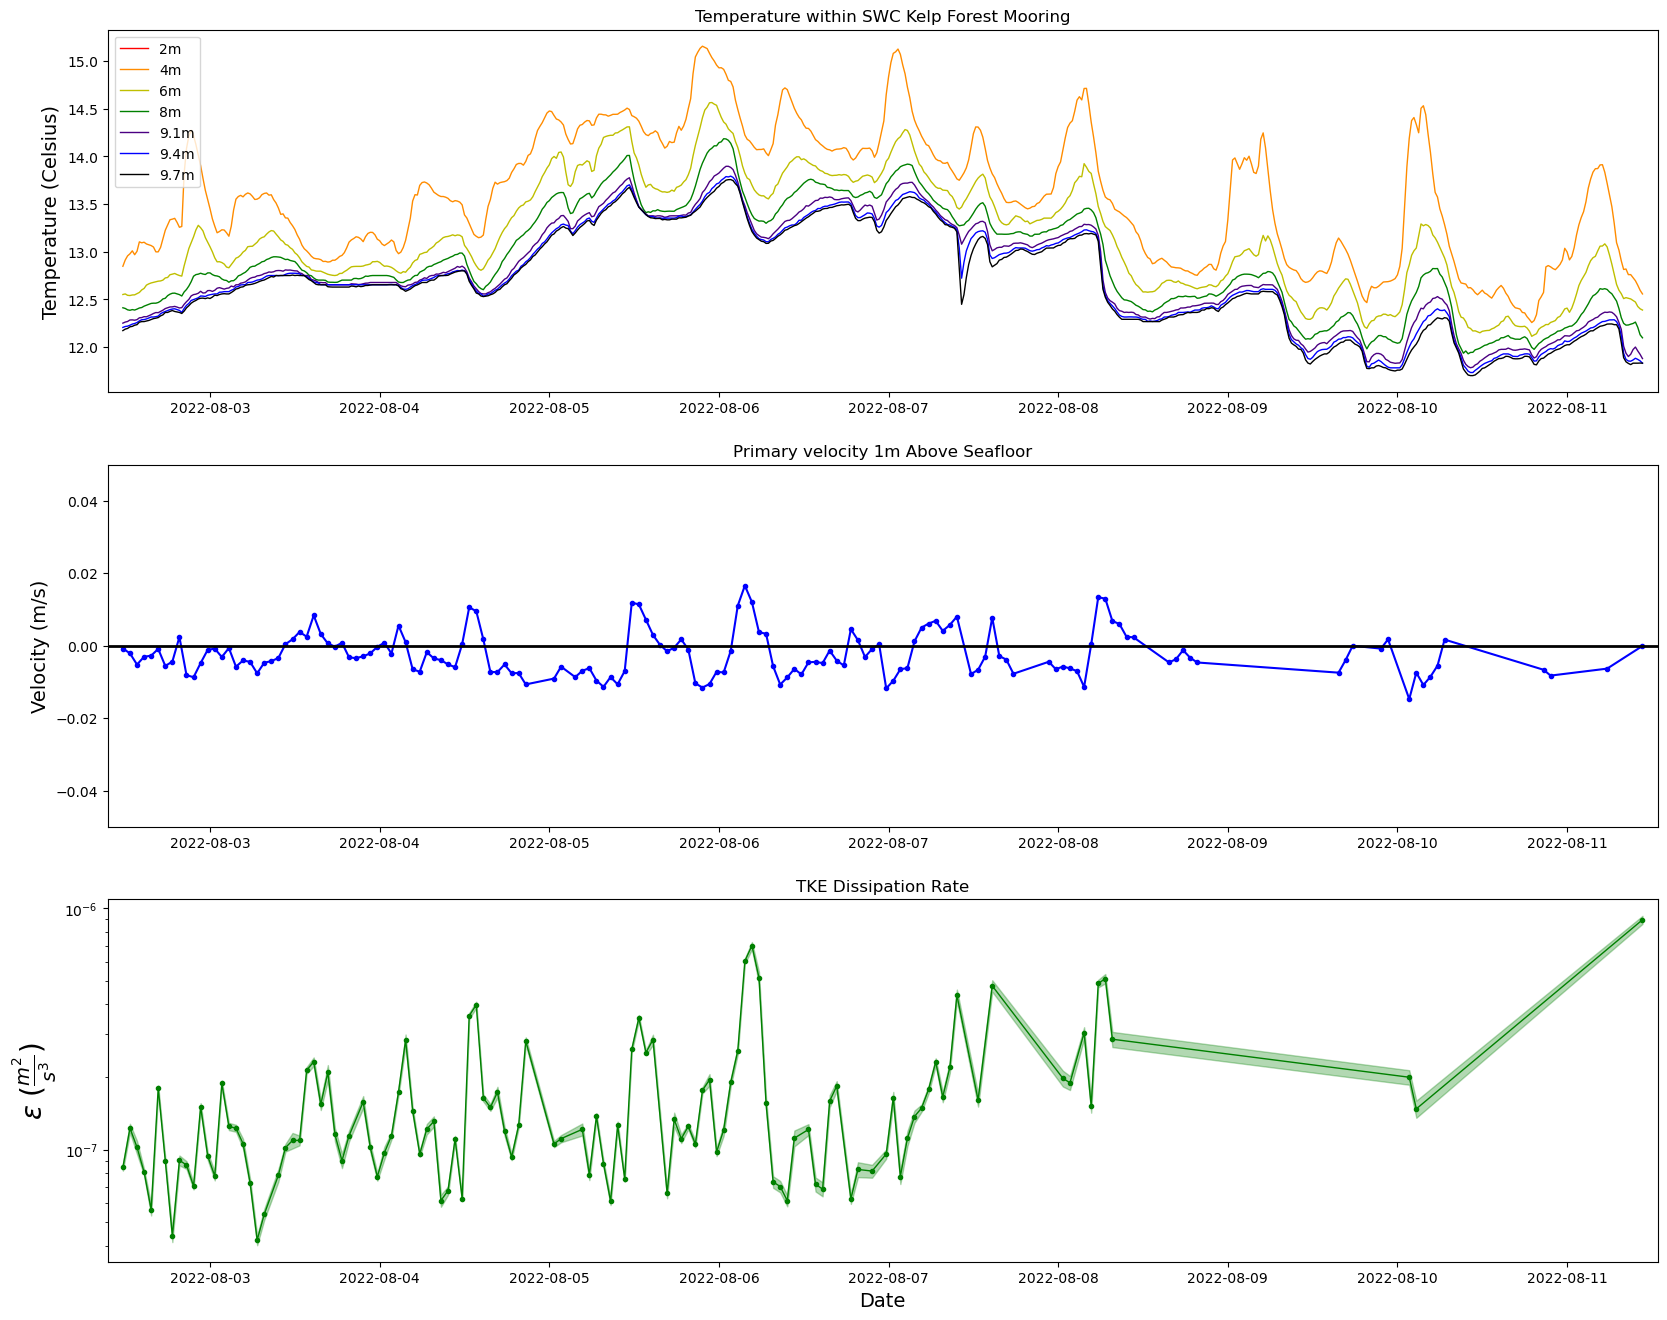

In [29]:
vt.vecEpsPlotter(adv1IntAvg, temp, eps1, timeFrame = None)
                           #saveFig=True, filename = 'Plots/Deployment2_vec_overview', returnBnum = True)

### Cooling events of deployment 1
Over the course of three days from August 4th to the 7th, multiple cooling events occur

array([43., 44., 45., 52., 53., 54., 55., 75., 76., 77., 78., 80., 81.,
       88., 89., 90., 91., 92., 93., 94., 95., 96.])

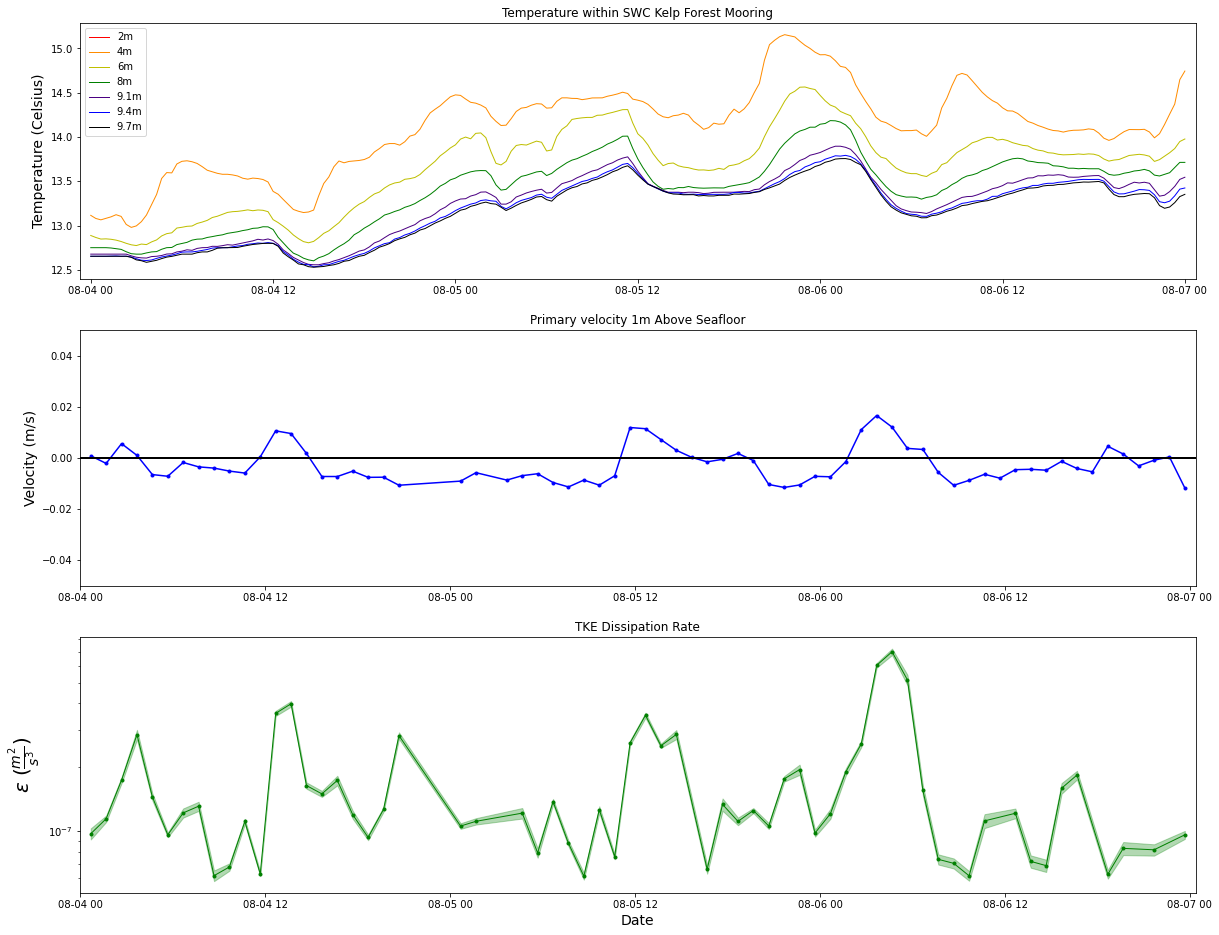

In [22]:
dep1CEB = vt.vecEpsPlotter(adv1IntAvg, temp, eps1IntAvg, timeFrame = ['2022-08-04T00:00:00.000000000','2022-08-07T00:00:00.000000000'],
                           saveFig=True, filename = 'Plots/Deployment1_804_807', returnBnum = True)
dep1CEB = dep1CEB[np.array([3,4,5,12,13,14,15,30,31,32,33,34,35,42,43,44,45,46,47,48,49,50])]
dep1CEB

In [ ]:
vt.vecEpsPlotter(adv1IntAvg, temp, eps1IntAvg, timeFrame = ['2022-08-05T00:00:00.000000000','2022-08-07T00:00:00.000000000'])#, saveFig=True, filename = 'Plots/0807_0809_vec_overview')

In [ ]:
#Cooling event bursts
#Deployment 1:[52, 53], [75,76,77], [91,92,93]
#Deployment 2:[6,7,8], [55], [168,169]

In [101]:
eps1.bNum.where(eps1.epsLRPval > .01, drop = True)

<xarray.DataArray 'bNum' (bNum: 53)>
array([  3.,   4.,   6.,   8.,   9.,  12.,  13.,  14.,  16.,  17.,  18.,
        19.,  21.,  26.,  29.,  30.,  39.,  41.,  42.,  44.,  45.,  50.,
        51.,  52.,  53.,  54.,  55.,  58.,  59.,  64.,  65.,  70.,  71.,
        72.,  74.,  75.,  76.,  77.,  83.,  84.,  85.,  87.,  89.,  90.,
        91.,  92., 103., 104., 116., 117., 118., 141., 218.])
Coordinates:
  * bNum     (bNum) float64 3.0 4.0 6.0 8.0 9.0 ... 117.0 118.0 141.0 218.0

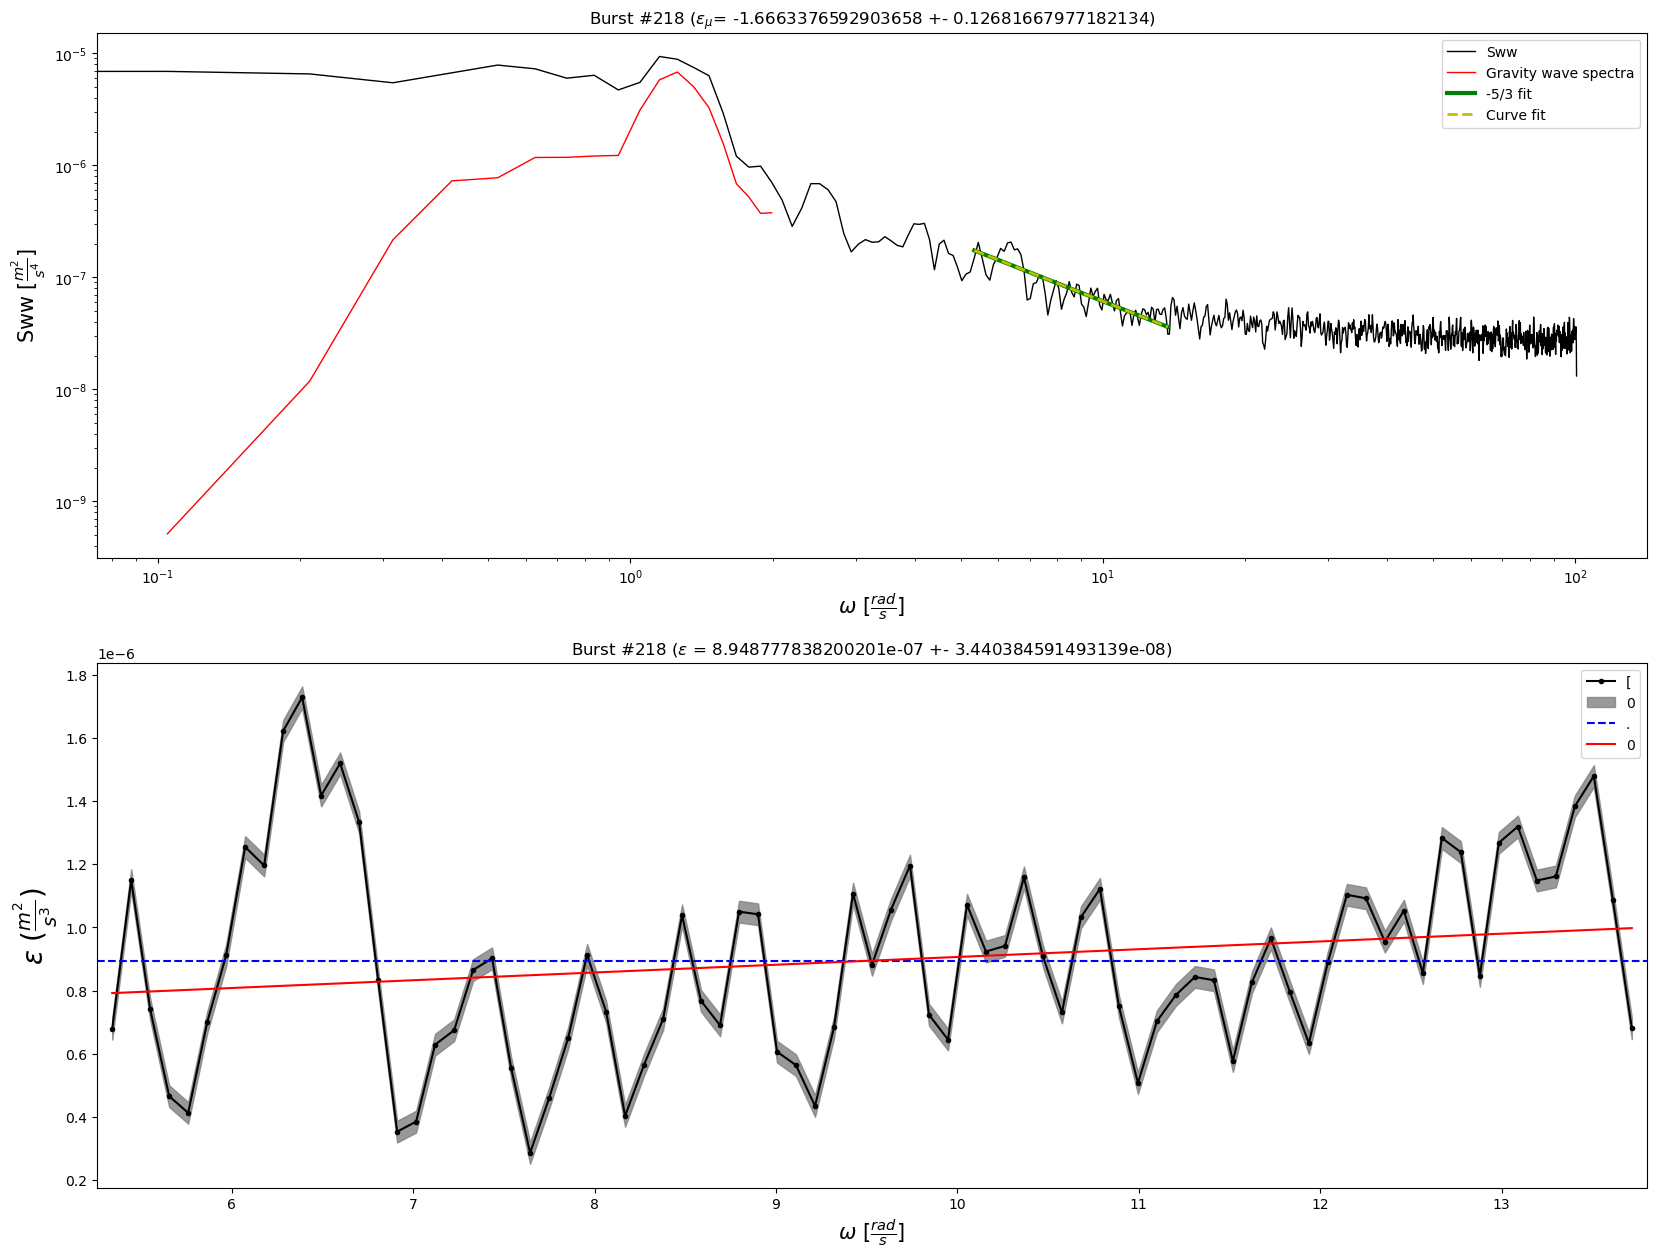

In [100]:
vt.epsSpectraPlotter(eps1, 218)